In [371]:
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pickle as cp 
import matplotlib.pyplot as plt

In [372]:
class NBC:
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types 
        self.num_classes = num_classes
    
    def fit(self, X, y):
        classes, classCounts = np.unique(y, return_counts=True)
        
        pis = np.expand_dims(classCounts / y.shape[0], axis=1)
        
        allMus = [] 
        allSigmaSqrs = []
        
        for i in range(classes.shape[0]):
            # Get class examples  
            classExampleIdxs = np.argwhere(y==classes[i])[:,0]
        
            # Calculate class parameters
            # Empirical mean / Bernoulli distribution parameter
            mus = np.average(X[classExampleIdxs,:], axis=0)
            # Emperical variance 
            sigmaSqrs = np.var(X[classExampleIdxs,:], axis=0)
            
            allMus.append(mus)
            allSigmaSqrs.append(sigmaSqrs)
        
        allMus = np.array(allMus)
        allSigmaSqrs = np.array(allSigmaSqrs)
        
        self.pis = pis
        self.mus = allMus
        self.sigmaSqrs = allSigmaSqrs
        self.classes = classes
        self.classCounts = classCounts
    
    def calcRealProb(self, X, realIndices, clsIdx): 
        mean = self.mus[clsIdx,realIndices]
        variances = self.sigmaSqrs[clsIdx,realIndices] 
        realXs = X[:,realIndices]
        probs = np.exp(-np.square(realXs-mean)/(2*(variances+1e-6)))/np.sqrt(2*np.pi*(variances+1e-6))
        return probs
    
    def calcCatProb(self, X, binIndices, clsIdx):
        params = self.mus[clsIdx,binIndices]
        binXs = X[:,binIndices]
        probs = np.zeros_like(binXs) 
        for i in range(params.shape[0]):
            feature = binXs[:,i]
            featureProbs = np.zeros_like(feature)
            featureProbs[feature == 1] = params[i]
            featureProbs[feature == 0] = 1 - params[i]
            probs[:,i] = featureProbs
        return probs
        
    def calcClassProb(self, X, clsIdx):
        featureTypes = self.feature_types
        binIndices = [i for i, x in enumerate(featureTypes) if x == 'b']
        realIndices = [i for i, x in enumerate(featureTypes) if x == 'r']
        
        realProbs = self.calcRealProb(X, realIndices, clsIdx)
        catProbs = self.calcCatProb(X, binIndices, clsIdx)
        
        # Ensure no zeros
        realProbs[realProbs == 0] = 1e-6
        catProbs[catProbs == 0] = 1e-6
        
        realProbs = np.log(realProbs)
        catProbs = np.log(catProbs)
        realProbs = np.sum(realProbs,axis=1)
        catProbs = np.sum(catProbs, axis=1)
        
        return realProbs + catProbs + \
            (np.log(self.pis[clsIdx]))
    
    def predict(self, X):
        classProbs = []
        for i in range(self.classes.shape[0]):
            classProbs.append(self.calcClassProb(X, i))
        classProbs = np.array(classProbs)
        predictedClassIdx = np.argmax(classProbs,axis=0)
        return self.classes[predictedClassIdx]
        

In [373]:
nbc = NBC(feature_types=['b','r','b','r'], num_classes=2)
nbc.fit(np.array([[[1],[0.5],[1],[0.5]],[[1],[0.5],[0],[0.5]],[[1],[0.5],[0],[0.5]]]),np.array([[2],[0],[2]]))

In [374]:
# Hand-in 1: 
# The value of C: 0.5 * 10.0 = 5.0

In [375]:
# Iris Dataset 
iris = load_iris() 
XIris, yIris = iris['data'], iris['target']
XTrainIris, XTestIris, yTrainIris, yTestIris =\
    train_test_split(XIris, yIris, test_size=0.25)
XTrainIris = np.expand_dims(XTrainIris,axis=2)
XTestIris = np.expand_dims(XTestIris,axis=2)
yTrainIris = np.expand_dims(yTrainIris,axis=1)
yTestIris = np.expand_dims(yTestIris,axis=1)

nbc = NBC(feature_types=['r','r','r','r'], num_classes=3)
nbc.fit(XTrainIris, yTrainIris)
nbcYTrainPredict = nbc.predict(XTrainIris)
nbcYTestPredict = nbc.predict(XTestIris)
nbcTrainAccuracy = np.mean(nbcYTrainPredict == yTrainIris)
nbcTestAccuracy = np.mean(nbcYTestPredict == yTestIris)

logReg = LogisticRegression(\
    solver='lbfgs', multi_class='multinomial', max_iter=1000)
logReg.fit(np.squeeze(XTrainIris), np.squeeze(yTrainIris))
logRegYTrainPredict = logReg.predict(np.squeeze(XTrainIris))
logRegYTestPredict = logReg.predict(np.squeeze(XTestIris))
logRegTrainAccuracy = np.mean(logRegYTrainPredict == yTrainIris)
logRegTestAccuracy = np.mean(logRegYTestPredict == yTestIris)

print("Naive Bayes Training Accuracy", nbcTrainAccuracy)
print("Naive Bayes Test Accuracy", nbcTestAccuracy)
print("Logistic Regression Training Accuracy", logRegTrainAccuracy)
print("Logistic Regression Test Accuracy", logRegTestAccuracy)

Naive Bayes Training Accuracy 0.9553571428571429
Naive Bayes Test Accuracy 0.9473684210526315
Logistic Regression Training Accuracy 0.33529974489795916
Logistic Regression Test Accuracy 0.3379501385041551


In [376]:
# Congressional Voting Records 
XVote, yVote = cp.load(open('voting.pickle', 'rb'))
featureTypes = ['b' for i in range(XVote.shape[1])]
XTrainVote, XTestVote, yTrainVote, yTestVote = \
    train_test_split(XVote, yVote, test_size=0.25)
XTrainVote = np.expand_dims(XTrainVote,axis=2)
XTestVote = np.expand_dims(XTestVote,axis=2)
yTrainVote = np.expand_dims(yTrainVote,axis=1)
yTestVote = np.expand_dims(yTestVote,axis=1)

nbc = NBC(feature_types=featureTypes, num_classes=2)
nbc.fit(XTrainVote, yTrainVote)
nbcYTrainPredict = nbc.predict(XTrainVote)
nbcYTestPredict = nbc.predict(XTestVote)
nbcTrainAccuracy = np.mean(nbcYTrainPredict == yTrainVote)
nbcTestAccuracy = np.mean(nbcYTestPredict == yTestVote)

logReg = LogisticRegression(\
    solver='lbfgs', max_iter=1000)
logReg.fit(np.squeeze(XTrainVote), np.squeeze(yTrainVote))
logRegYTrainPredict = logReg.predict(np.squeeze(XTrainVote))
logRegYTestPredict = logReg.predict(np.squeeze(XTestVote))
logRegTrainAccuracy = np.mean(logRegYTrainPredict == yTrainVote)
logRegTestAccuracy = np.mean(logRegYTestPredict == yTestVote)

print("Naive Bayes Training Accuracy", nbcTrainAccuracy)
print("Naive Bayes Test Accuracy", nbcTestAccuracy)
print("Logistic Regression Training Accuracy", logRegTrainAccuracy)
print("Logistic Regression Test Accuracy", logRegTestAccuracy)

Naive Bayes Training Accuracy 0.9195402298850575
Naive Bayes Test Accuracy 0.896551724137931
Logistic Regression Training Accuracy 0.5001321178491214
Logistic Regression Test Accuracy 0.5267538644470868


In [377]:
# Split data 
def splitData(X,y):
    XTrain, XTest, yTrain, yTest = \
    train_test_split(X, y, test_size=0.25)
    XTrain = np.expand_dims(XTrain,axis=2)
    XTest = np.expand_dims(XTest,axis=2)
    yTrain = np.expand_dims(yTrain,axis=1)
    yTest = np.expand_dims(yTest,axis=1)
    return XTrain, XTest, yTrain, yTest

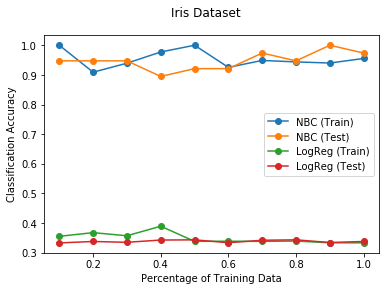

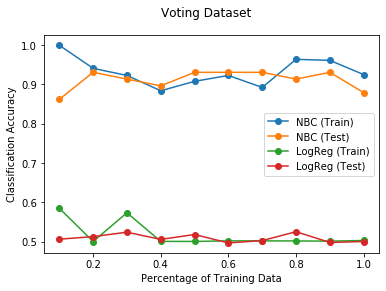

In [378]:
# Hand-in 2
# Learning Curves of NBC and LogReg
def getLearningCurveNBC(X, y, estimator):
    dataPerc = np.linspace(0.1,1.0,10)
    numPerm = 1 
    trainAccuracies = []
    testAccuracies = []
    for i in range(len(dataPerc)):
        totTrainAccuracy = 0
        totTestAccuracy = 0 
        for j in range(numPerm):
            XTrain, XTest, yTrain, yTest = splitData(X,y)
            numTrain = XTrain.shape[0]
            numTrainSub = int(dataPerc[i] * numTrain)
            XTrainSub = XTrain[:numTrainSub]
            yTrainSub = yTrain[:numTrainSub]
            estimator.fit(XTrainSub, yTrainSub)
            yTrainPredict = estimator.predict(XTrainSub)
            yTestPredict = estimator.predict(XTest)
            totTrainAccuracy += \
                np.mean(yTrainPredict \
                == yTrainSub)
            totTestAccuracy += \
                np.mean(yTestPredict == yTest)
        trainAccuracies.append(totTrainAccuracy / numPerm)
        testAccuracies.append(totTestAccuracy / numPerm)
    return trainAccuracies, testAccuracies

def getLearningCurveLogReg(X, y, estimator):
    dataPerc = np.linspace(0.1,1.0,10)
    numPerm = 1 
    trainAccuracies = []
    testAccuracies = []
    for i in range(len(dataPerc)):
        totTrainAccuracy = 0
        totTestAccuracy = 0 
        for j in range(numPerm):
            XTrain, XTest, yTrain, yTest = splitData(X,y)
            numTrain = XTrain.shape[0]
            numTrainSub = int(dataPerc[i] * numTrain)
            XTrainSub = XTrain[:numTrainSub]
            yTrainSub = yTrain[:numTrainSub]
            estimator.fit(np.squeeze(XTrainSub), \
                np.squeeze(yTrainSub))
            yTrainPredict = estimator.predict( \
                np.squeeze(XTrainSub))
            yTestPredict = estimator.predict( \
                np.squeeze(XTest))
            totTrainAccuracy += \
                np.mean(yTrainPredict \
                == yTrainSub)
            totTestAccuracy += \
                np.mean(yTestPredict == yTest)
        trainAccuracies.append(totTrainAccuracy / numPerm)
        testAccuracies.append(totTestAccuracy / numPerm)
    return trainAccuracies, testAccuracies

nbc = NBC(feature_types=featureTypes, num_classes=2)
nbcVoteTrainCurve, nbcVoteTestCurve = \
    getLearningCurveNBC(XVote, yVote, nbc)

nbc = NBC(feature_types=['r','r','r','r'], num_classes=3)
nbcIrisTrainCurve, nbcIrisTestCurve = \
    getLearningCurveNBC(XIris, yIris, nbc)

logReg = LogisticRegression(\
    solver='lbfgs', max_iter=1000)
logRegVoteTrainCurve, logRegVoteTestCurve = \
    getLearningCurveLogReg(XVote, yVote, logReg)

logReg = LogisticRegression(\
    solver='lbfgs', multi_class='multinomial', max_iter=1000)
logRegIrisTrainCurve, logRegIrisTestCurve = \
    getLearningCurveLogReg(XIris, yIris, logReg)

plt.figure()
plt.plot(dataPerc, nbcIrisTrainCurve, '-o', label='NBC (Train)')
plt.plot(dataPerc, nbcIrisTestCurve, '-o', label='NBC (Test)')
plt.plot(dataPerc, logRegIrisTrainCurve, '-o', label='LogReg (Train)')
plt.plot(dataPerc, logRegIrisTestCurve, '-o', label='LogReg (Test)')
plt.xlabel("Percentage of Training Data")
plt.ylabel("Classification Accuracy")
plt.suptitle("Iris Dataset")
plt.legend()

plt.figure()
plt.plot(dataPerc, nbcVoteTrainCurve, '-o', label='NBC (Train)')
plt.plot(dataPerc, nbcVoteTestCurve, '-o', label='NBC (Test)')
plt.plot(dataPerc, logRegVoteTrainCurve, '-o', label='LogReg (Train)')
plt.plot(dataPerc, logRegVoteTestCurve, '-o', label='LogReg (Test)')
plt.xlabel("Percentage of Training Data")
plt.ylabel("Classification Accuracy")
plt.suptitle("Voting Dataset")
plt.legend()

In [379]:
class NBC2:
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types 
        self.num_classes = num_classes
    
    def fit(self, X, y):
        classes, classCounts = np.unique(y, return_counts=True)
        
        pis = np.expand_dims(classCounts / y.shape[0], axis=1)
        
        allParams = []
        
        for i in range(classes.shape[0]):
            # Get class examples  
            classExampleIdxs = np.argwhere(y==classes[i])[:,0]
        
            # Calculate class parameters
            # Bernoulli distribution parameter
            numOnes = np.count_nonzero(X == 1, axis=0)
            numZeros = np.count_nonzero(X == 0, axis=0)
            allParams.append(np.divide(numOnes, numOnes + numZeros))
            
        allParams = np.array(allParams)
        
        self.pis = pis
        self.params = allParams
        self.classes = classes
        self.classCounts = classCounts 

    def calcCatProb(self, X, binIndices, clsIdx):
        params = self.params[clsIdx,binIndices]
        binXs = X[:,binIndices]
        probs = np.zeros_like(binXs) 
        for i in range(params.shape[0]):
            feature = binXs[:,i]
            featureProbs = np.zeros_like(feature)
            featureProbs[feature == 1] = params[i]
            featureProbs[feature == 0] = 1 - params[i]
            probs[:,i] = featureProbs
        return probs
        
    def calcClassProb(self, X, clsIdx):
        featureTypes = self.feature_types
        binIndices = [i for i, x in enumerate(featureTypes) if x == 'b']
        realIndices = [i for i, x in enumerate(featureTypes) if x == 'r']
        
        catProbs = self.calcCatProb(X, binIndices, clsIdx)
        # Ensure no zeros 
        catProbs[catProbs == 0] = 1e-6
        
        # Catch empty entries 
        catProbs[catProbs != 2] = np.log(catProbs[catProbs != 2])
        catProbs[catProbs == 2] = 0 
        
        # Calculate probability
        catProbs = np.sum(catProbs, axis=1)
        
        return catProbs + \
            (self.classCounts * np.log(self.pis[clsIdx]))
    
    def predict(self, X):
        classProbs = []
        for i in range(self.classes.shape[0]):
            classProbs.append(self.calcClassProb(X, i))
        classProbs = np.array(classProbs)
        predictedClassIdx = np.argmax(classProbs,axis=0)
        return self.classes[predictedClassIdx]
        

In [383]:
# Congressional Voting Records (Full)
XVoteFull, yVoteFull = cp.load(open('voting-full.pickle', 'rb'))
featureTypes = ['b' for i in range(XVote.shape[1])]
nbc2 = NBC2(feature_types=featureTypes, num_classes=2)
XVoteFTrain, XVoteFTest, yVoteFTrain, yVoteFTest = \
    splitData(XVoteFull, yVoteFull)
nbc2.fit(XVoteFTrain, yVoteFTrain)
nbcYTrainPredict = nbc2.predict(XVoteFTrain)
nbcYTestPredict = nbc2.predict(XVoteFTest)
nbcTrainAccuracy = np.mean(nbcYTrainPredict == yVoteFTrain)
nbcTestAccuracy = np.mean(nbcYTestPredict == yVoteFTest)
print("Naive Bayes (Train):", nbcTrainAccuracy)
print("Naive Bayes (Test):", nbcTestAccuracy)

logReg = LogisticRegression(\
    solver='lbfgs', max_iter=1000)

XVoteFTrainZeros = np.copy(XVoteFTrain)
XVoteFTrainZeros[XVoteFTrainZeros == 2] = 0
XVoteFTestZeros = np.copy(XVoteFTest)
XVoteFTestZeros[XVoteFTestZeros == 2] = 0

logReg.fit(np.squeeze(XVoteFTrainZeros), np.squeeze(yVoteFTrain))

logRegYTrainPredict = logReg.predict(np.squeeze(XVoteFTrainZeros))
logRegYTestPredict = logReg.predict(np.squeeze(XVoteFTestZeros))
logRegTrainAccuracy = np.mean(logRegYTrainPredict == yVoteFTrain)
logRegTestAccuracy = np.mean(logRegYTestPredict == yVoteFTest)
print("Logistic Regression (Train):", logRegTrainAccuracy)
print("Logistic Regression (Test):", logRegTestAccuracy)

Naive Bayes (Train): 0.6349693251533742
Naive Bayes (Test): 0.5504587155963303
Logistic Regression (Train): 0.5356054047950619
Logistic Regression (Test): 0.5097214039222288
